# Sentence pairs testing Demo and Error analysis

In [172]:
import sys
print(sys.executable)
import nltk
from nltk import word_tokenize
nltk.download('punkt')
import dill
from torchtext import data
import torch
import torchtext.vocab as vocab
from torchtext.data import Field 
from nltk import word_tokenize
from prepare_SNLI import *
from utils_eval import *

print(device)


from collections import Counter

/Users/AS/anaconda3/envs/atcs-nli-representations/bin/python
cpu


[nltk_data] Downloading package punkt to /Users/AS/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### LSTM

In [173]:
with open("TEXT.Field","rb")as f:
     text=dill.load(f)
train_iter, dev_iter, test_iter = [],[],[]

In [174]:
#Arguments for LSTM
class Args:
    model_name = 'LSTM'
    seed = 42
    checkpoint_path = "lisalogs/LSTM/checkpoints/epoch=8-step=72963.ckpt"
#     checkpoint_path = "lisalogs/BiLSTM/checkpoints/epoch=8-step=77255.ckpt"
    path_for_logs = 'Successful_eval'
    tokenize = True
    hidden_dim = 2048
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

args_LSTM=Args()

In [175]:
cp_path = args_LSTM.checkpoint_path

logger = TensorBoardLogger('Successful_eval', name= args_LSTM.model_name)
trainer = Trainer(
        logger=logger,
    )
model_LSTM = Recurrent.load_from_checkpoint(
                                         cp_path,config = args_LSTM, 
                                         text = text, 
                                         train_iter = train_iter, 
                                         dev_iter   = dev_iter,
                                         test_iter  = test_iter)
print(model_LSTM.nli_net.encoder.embedding)
# trainer.test(model_LSTM)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Embedding(37179, 300, padding_idx=1)


In [176]:
#Contradiction

premise = 'Two women are embracing while holding to go packages.'
hypothesis = 'The sisters are walking away and saying goodbye while holding to go packages after just eating lunch.'

premise = word_tokenize(premise.lower())
hypothesis = word_tokenize(hypothesis.lower())

#embedding process
premise1 = text.process([premise])
# print(premise1[0], premise1[1])
hypothesis1 = text.process([hypothesis])


# torch.argmax(model_AWE((premise1,hypothesis1)))
print(model_LSTM.nli_net(premise1,hypothesis1))
print(torch.argmax(model_LSTM.nli_net(premise1,hypothesis1)))

tensor([[-3.5862,  1.7380,  1.6283]], grad_fn=<AddmmBackward>)
tensor(2)


In [177]:
#Entailment

premise = 'Two men are talking about money'
hypothesis = 'The men are discussing finances'

premise = word_tokenize(premise.lower())
hypothesis = word_tokenize(hypothesis.lower())

#embedding process
premise1 = text.process([premise])
hypothesis1 = text.process([hypothesis])


# torch.argmax(model_AWE((premise1,hypothesis1)))
print(model_LSTM.nli_net(premise1,hypothesis1))
print(torch.argmax(model_LSTM.nli_net(premise1,hypothesis1)))

tensor([[ 2.2153, -2.3160,  0.1296]], grad_fn=<AddmmBackward>)
tensor(0)


In [178]:
#Neutral

premise = 'Two parents are meeting in the hall'
hypothesis = 'Two dads are meeting in the dining room'

premise = word_tokenize(premise.lower())
hypothesis = word_tokenize(hypothesis.lower())

#embedding process
premise1 = text.process([premise])
hypothesis1 = text.process([hypothesis])


print(model_LSTM.nli_net(premise1,hypothesis1))
print(torch.argmax(model_LSTM.nli_net(premise1,hypothesis1)))

tensor([[-1.9608,  2.1000, -0.2211]], grad_fn=<AddmmBackward>)
tensor(1)


In [179]:
import sys
import datetime, os
print(sys.executable)

/Users/AS/anaconda3/envs/atcs-nli-representations/bin/python


## Tensorboard: best val resutls

In [180]:
# tensorboard --logdir='lisalogs'
%tensorboard --logdir 'lisalogs'

Reusing TensorBoard on port 6006 (pid 2417), started 2:28:18 ago. (Use '!kill 2417' to kill it.)

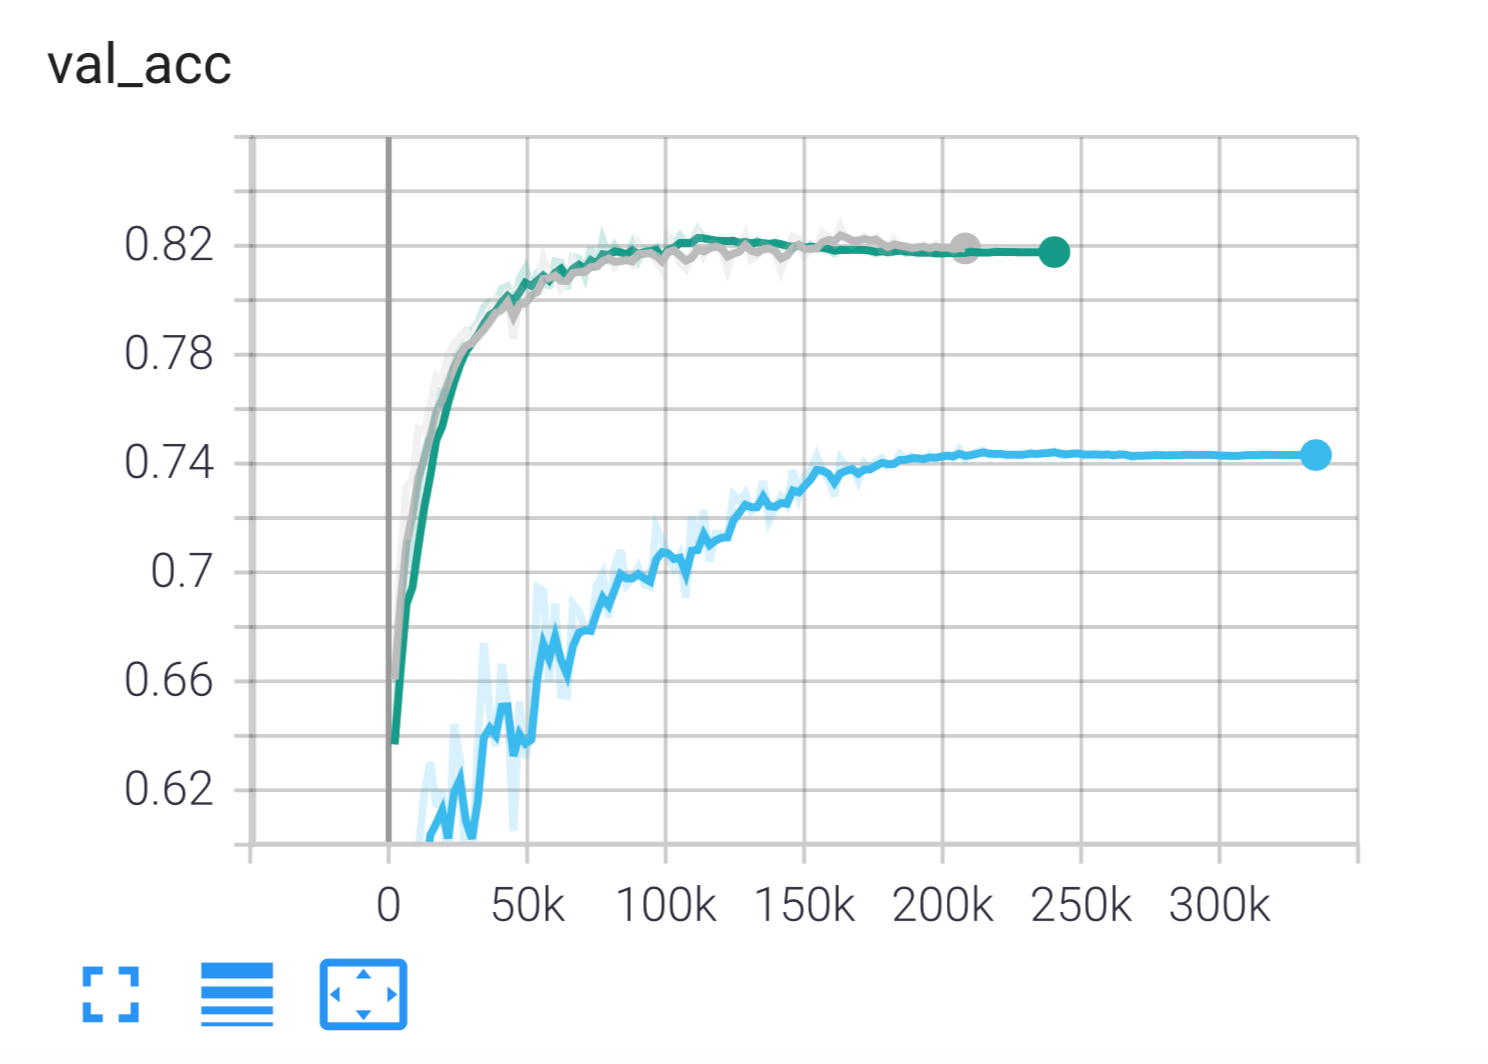

In [26]:
from IPython.display import Image
Image(filename='Accuracies.png')


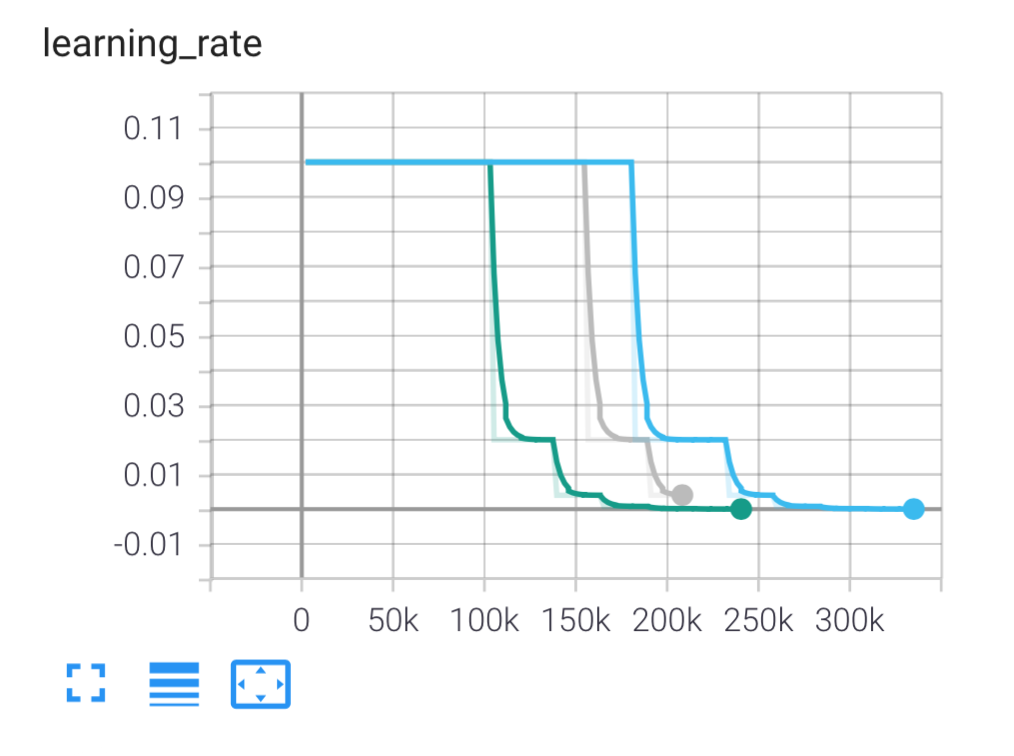

In [27]:
Image(filename='Learning_rates.png')

#### Where blue corresponds to AWE and green and gray are LSTM and BiLSTM respectively

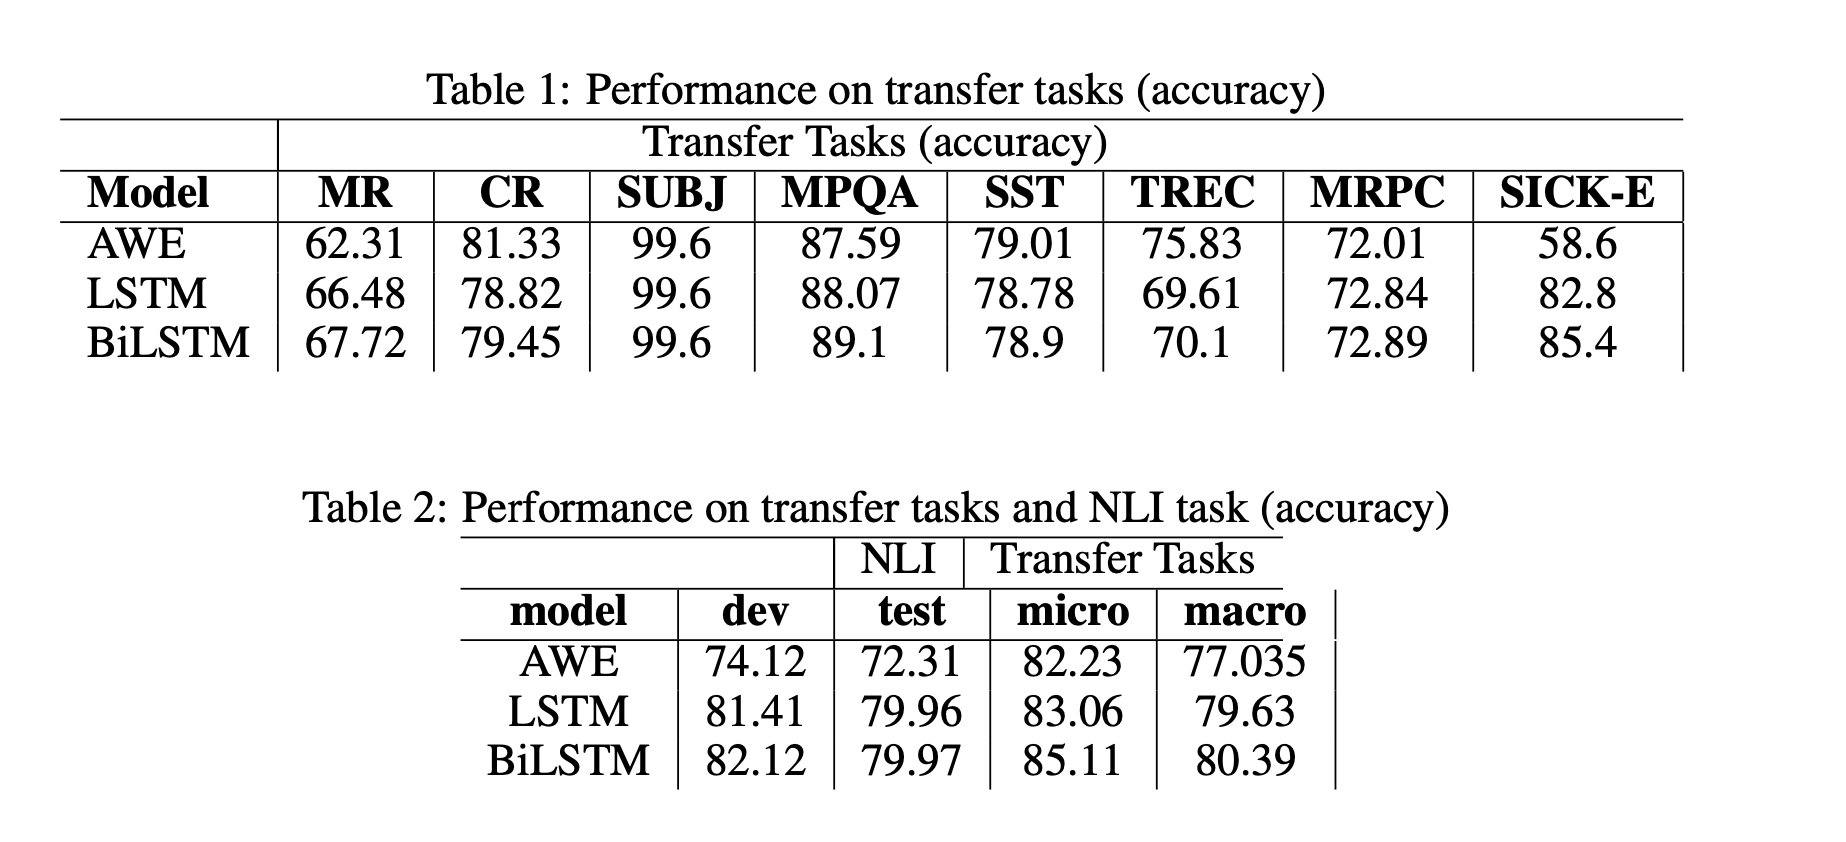

In [171]:
Image(filename='main_tables.png')

# Results and Error Analysis

One can see clearly from table 2 that the LSTM model performs surprisingly better on transfer tasks, than on the NLI, on which it was trained which can be attributed to high performance on SUBJ and MPQA tasks. The classifier of the model was trained with dropout value of $0.1$, leading to a better generalization, which could also be one of the reasons for such a high performance on the  tasks outside of the NLI task. What was surprising also is that the values on SUBJ tasks outperformed the values the ones reported in the paper. 

It is apparent that AWE under-performs for computationally demanding metrics such as SICK-E, due to probably lower complexity of the model.

One trend that is noticable is that AWE performs better on binary or multi-class classification tasks such as: MR,SST,MPQA,CR. It is particularly interesting that on CR and MPQA metric AWE outperformed more complex architectures. It could be that by under-performing on NLI task, it gained more generalizable embeddings, that are very efficient across those tasks. It also explains why it performed so poorly  on SICK-E: SICK-E can be considered as an out-of-sample NLI task.

Regarding BiLSTM, main conclusion is that it did not have a strong impact on the performance in general, despite of considerably longer training time. One can only see strong ~3\% improvement for SICK-E task, while having marginal improvement on NLI task itself.